<a href="https://colab.research.google.com/github/arkincognito/ML-from-scrap/blob/master/0604_MiniBatch_BatchNormalization_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Very BROOT and Somewhat unorganized Minibatch & Batch Normalization coding from scratch

This notebook is from my first days of python coding and ML studies.
It is messy and less organized.
It's just a reference to my studies in ML.

This notebook is based on the study materials from DS School.

## Goal of this practice

I'll code a Minibatch and Batch Normalization Multi Layer Perceptron model using numpy. Dataset I'll use is MNIST handwriting dataset.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore') # 경고 메시지를 숨길 수 있습니다.

**1. MNIST Dataset**
> Handwritten integers are given as 28 by 28 grayscale image. Each image has a label denoting the number from 0 to 9. Each pixel holds value from 0, the darkest, to 255, the brightest.

**2. Train, Test Set**
> 60,000 train data and 10,000 test data are given. We'll divide the training dataset into 50,000 training set and 10,000 validation set.

Let's load the MNIST dataset and divide the training dataset. I'll assume that the datasets are random and evenly distributed, and pull the first 10,000 data from the training set to make the validation set.

In [6]:
from keras.datasets import mnist

((X_train, y_train), (X_test, y_test)) = mnist.load_data()

X_validate = X_train[:10000]
y_validate = y_train[:10000]

X_train = X_train[10000:]
y_train = y_train[10000:]

print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(50000, 28, 28) (50000,)
(10000, 28, 28) (10000,)
(10000, 28, 28) (10000,)


[3 8 7 9 9 0 1 1 5 2]


<Figure size 432x288 with 0 Axes>

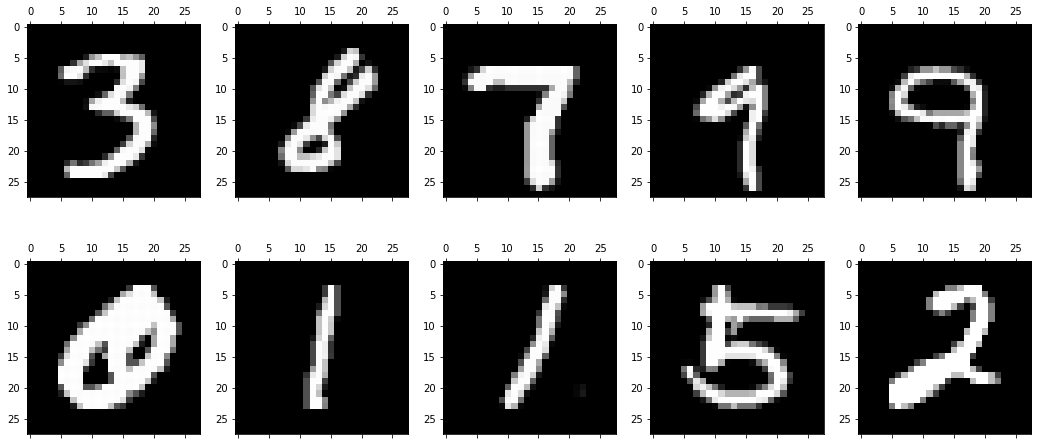

In [7]:
# Take a brief look at the MNIST dataset.
import matplotlib.pyplot as plt
%matplotlib inline

plt.gray() # plot in grayscale
nrows, ncols = 2, 5
figures, axes = plt.subplots(nrows=nrows, ncols=ncols)
figures.set_size_inches(18, 8)

 # train set 10개만 보겠습니다.
print(y_train[0:10])

for row in range(nrows):
  for col in range(ncols):
    axes[row][col].matshow(X_train[row*5 + col])

## Preprocessing
There is no preprocessing for the dataset required, so I'll move on to coding the MLP with Minibatch and Batch Normalization.

### Define Sigmoid

In [ ]:
# Define sigmoid function so we could use as the activation function.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

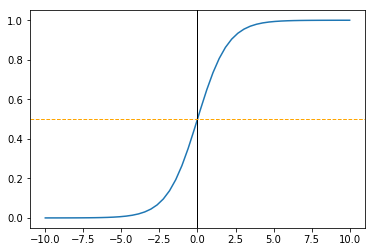

In [ ]:
# A quick view of the shape of sigmoid function between -10 and 10.
xx = np.linspace(-10, 10)
yy = sigmoid(xx)
plt.plot(xx, yy)

plt.axvline(x=0, color="black", linewidth=1) 
plt.axhline(y=0.5, linestyle='--', color="orange", linewidth=1)
plt.show()

# Sigmoid's value is bound between -1 and 1.
# Sigmoid(0) = 0.5

### Define Cross Entropy

In [ ]:
# loss function으로써 cross entropy를 정의해줍니다.
def cross_entropy(actual, predict, eps=1e-15):
    
    # 실제 값과 예측 값을 Numpy 배열로 바꿔줍니다.
    actual = np.array(actual)
    predict = np.array(predict)
    
    # 0이 log에 들어가게 되면 무한대로 발산해버릴 수 있으니 아주 작은 값을 넣어 이를 방지합니다.
    clipped_predict = np.minimum(np.maximum(predict, eps), 1 - eps)
    
    # 실질적인 Loss를 계산합니다
    loss = actual * np.log(clipped_predict) + (1 - actual) * np.log(1 - clipped_predict)
    
    return -1.0 * loss.mean()

### Define derivative of sigmoid

In [ ]:
# derivative of sigmoid function
def dsigmoid(A):
    # sigmoid 함수를 미분하면 출력값 * (1-출력값)과 같습니다.
    dA = A * (1 - A)
    return dA

# Data reshape

In [ ]:
from keras.utils import to_categorical
X_train = X_train.reshape(60000, 28 * 28)
# 이때 각각의 원소는 픽셀의 값으로, 0~255 사이의 값을 가질 것입니다.
X_test = X_test.reshape(10000, 28 * 28)

# 주어진 데이터는 0~9까지 10개의 라벨을 갖습니다.
# 각 라벨에 해당하는 경우 1, 아니면 0이 되도록 One hot encoding을 해줍니다.

y_train_hot = to_categorical(y_train) # np.eye(10)[y_train]과 동일
y_test_hot = to_categorical(y_test) # np.eye(10)[y_test]와 동일

print(y_train_hot.shape)
print(y_test_hot.shape)

(60000, 10)
(10000, 10)


In [ ]:
# 퍼셉트론 알고리즘에 투입하는 X, y를 transpose해줍니다.
X_train = X_train.T
y_train_hot = y_train_hot.T
print(X_train.shape, y_train_hot.shape)
# train set의 경우 (784, 60000), (10, 60000)입니다.

X_test = X_test.T
y_test_hot = y_test_hot.T
print(X_test.shape, y_test_hot.shape)
# test set의 경우 (784, 60000), (10, 10000)입니다.

(784, 60000) (10, 60000)
(784, 10000) (10, 10000)


## Solving MNIST problem using Multi-layer Neural Network with Mini Batch and Batch Normalization

Single hidden layer with 1000 nodes with sigmoid activation and Batch Normalization applied.

In [ ]:
np.random.seed(10)

w1 = np.random.uniform(-1.0, high = 1.0, size = (1000,28 * 28))
b1 = np.random.uniform(-1.0, high = 1.0, size = (1000,1))
w2 = np.random.uniform(-1.0, high = 1.0, size = (10,1000))
b2 = np.random.uniform(-1.0, high = 1.0, size = (10,1))
g = np.random.uniform(-2.0, 2.0, size = (1000, 1))
b = np.random.uniform(-2.0, 2.0, size = (1000, 1))

batch_size = 16
learning_rate = 0.3
# Small Learning Rate will reduce the internal covarient shift
# but has the possibility of falling into local minimum
# By using Batch Norm, we reduce internal covarient shift, while allowing the large learning rate.

num_epoch = 10000
target_accuracy = 0.9999
num_data = X_train.shape[1]
num_batch = num_data // batch_size
accuracy_mean = 0
past_loss_mean = 0
loss_mean = 0
eps = 1e-15

print(f"num_data: {num_data}  num_batch: {num_batch}")

# Start Learning Process
for epoch in range(num_epoch):
    accuracy_status = True
    # Divide the whole dataset into Mini Batches
    for sample_run in range(num_batch):
        X = X_train[: ,sample_run * batch_size : (sample_run + 1) * batch_size]
        y = y_train_hot[:, sample_run * batch_size : (sample_run + 1) * batch_size]
        
        z1 = np.dot(w1, X) + b1 ## shape = (nodes, datas)
        
        # Applying Batch Normalization before Activation Function
        s1 = z1.var(axis = 1, keepdims = True) ## axis = 1 takes variance along datas.
        m1 = z1.mean(axis = 1, keepdims = True) ## becomes (nodes, 1)
        
        x_normalized = (z1 - m1)/(s1 + eps)**(1/2)
        y1 = x_normalized * g + b # Scaling and Shifting
        a1 = sigmoid(y1)
        z2 = np.dot(w2, a1) + b2
        a2 = sigmoid(z2)
        y_predict_hot = a2
        y_predict = np.argmax(y_predict_hot, axis=0) 
        accuracy = (np.equal(y_predict, y_train[sample_run * batch_size : (sample_run + 1) * batch_size])).mean()
        loss = cross_entropy(y, y_predict_hot)
        
        # Accuracy and Cross Entropy Loss is for the current Mini Batch.
        # By making a moving average on them calculate the accuracy over the whole dataset
        # 최근 num_batch 의 평균을 내겠습니다. (계산 횟수가 너무 늘어나는 단점이 있긴 한데...)
        cnt = min(epoch * num_batch + sample_run + 1, num_batch)
        accuracy_mean = (accuracy_mean * (cnt - 1) + accuracy) / cnt
        loss_mean = (loss * (cnt - 1) + loss) / cnt
        
        if accuracy_mean >= target_accuracy : break

        # Parameter update for BN on Sigmoid.
        d1 = a2 - y
        d2 = np.dot(w2.T, d1) * (dsigmoid(a1))
        dg = np.dot(x_normalized, d2.T).mean(axis = 1, keepdims = True)
        dx = d2 * g
        dm = (dx * (-1 / (s1 + eps)**2)).mean()
        ds = np.dot(x_normalized - m1, dx.T).mean(axis = 1, keepdims = True) * (-1*(s1 + eps)**(-3/2))/2
        dz1 = dx * 1 / (s1 + eps)**(1/2) + ds * 2 * (z1 - m1) / batch_size + dm / batch_size

        g -= learning_rate * dg
        b -= learning_rate * d2.mean(axis = 1, keepdims = True)
        w1 -= learning_rate * np.dot(dz1, X.T) / batch_size
        b1 -= learning_rate * dz1.mean(axis = 1, keepdims = True)
        w2 -= learning_rate * np.dot(d1, a1.T) / batch_size
        b2 -= learning_rate * d1.mean(axis = 1, keepdims = True)
        
#     if np.abs((past_loss_mean - loss_mean)) <= 0.00001: learning_rate /= 2
#     if learning_rate <= 0.005 : break
#     past_loss_mean = loss_mean
    if accuracy_mean >= target_accuracy : break    
    print("{0:2} accuracy = {1:.5f}, loss = {2:.5f}".format(epoch, accuracy_mean, loss_mean))
    
print("-----"*10)
print("{0:2} accuracy = {1:.5f}, loss = {2:.5f}".format(epoch, accuracy_mean, loss_mean))

num_data: 60000  num_batch: 3750
 0 accuracy = 0.82982, loss = 0.01447
 1 accuracy = 0.87198, loss = 0.00885
 2 accuracy = 0.90154, loss = 0.00465
 3 accuracy = 0.92098, loss = 0.00287
 4 accuracy = 0.93394, loss = 0.00243
 5 accuracy = 0.94304, loss = 0.00258
 6 accuracy = 0.94924, loss = 0.00326
 7 accuracy = 0.95356, loss = 0.00396
 8 accuracy = 0.95735, loss = 0.00436
 9 accuracy = 0.96056, loss = 0.00449
10 accuracy = 0.96290, loss = 0.00434
11 accuracy = 0.96529, loss = 0.00396
12 accuracy = 0.96729, loss = 0.00353
13 accuracy = 0.96906, loss = 0.00321
14 accuracy = 0.97088, loss = 0.00297
15 accuracy = 0.97240, loss = 0.00271
16 accuracy = 0.97418, loss = 0.00235
17 accuracy = 0.97578, loss = 0.00196
18 accuracy = 0.97713, loss = 0.00157
19 accuracy = 0.97840, loss = 0.00122
20 accuracy = 0.97963, loss = 0.00097
21 accuracy = 0.98064, loss = 0.00078
22 accuracy = 0.98152, loss = 0.00067
23 accuracy = 0.98248, loss = 0.00067
24 accuracy = 0.98360, loss = 0.00069
25 accuracy = 0.9

# Evaluate (Train)

In [ ]:
# Checking the Train results on the Train Data.
z1 = np.dot(w1, X_train[:, :10000]) + b1 ## shape = (nodes, datas)
s1 = z1.var(axis = 1, keepdims = True) ## axis = 1 takes variance along datas.
m1 = z1.mean(axis = 1, keepdims = True) ## becomes (nodes, 1)
x_normalized = (z1 - m1)/(s1 + eps)**(1/2)
y1 = x_normalized * g + b
a1 = sigmoid(y1)
z2 = np.dot(w2, a1) + b2
a2 = sigmoid(z2)
y_predict_hot = a2
y_predict = np.argmax(y_predict_hot, axis=0)

# actual vs. predict
train_result = pd.DataFrame({'actual': y_train[:10000], 'predict': y_predict})

# accuracy는 다음과 같이 계산됩니다.
train_accuracy = (train_result["actual"] == train_result["predict"]).mean()
print("Accuracy(train) = {0:.5f}".format(train_accuracy))

print(train_result.shape)
train_result.head(10)

Accuracy(train) = 0.99210
(10000, 2)


,actual,predict
0,5,5
1,0,0
2,4,4
3,1,1
4,9,9
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


### Evaluate (Test)

In [ ]:
# Applying on the Test Data

# normally, test data's get evaluated 1 by 1, which makes calculating m1 and s1 impossible.
# For this reason, we would get the average and variance of the training dataset and plug it into s1, m1.

# However, for the MNIST, we have large number of test data which we plug in at the same time,
# Thus we take mean and variance of the test dataset.

z1 = np.dot(w1, X_test) + b1 ## shape = (nodes, datas)
s1 = z1.var(axis = 1, keepdims = True) ## axis = 1 takes variance along datas.
m1 = z1.mean(axis = 1, keepdims = True) ## becomes (nodes, 1)
x_normalized = (z1 - m1)/(s1 + eps)**(1/2)
y1 = x_normalized * g + b
a1 = sigmoid(y1)
z2 = np.dot(w2, a1) + b2
a2 = sigmoid(z2)

y_predict_hot = a2
y_predict = np.argmax(y_predict_hot, axis=0)

# actual vs. predict
test_result = pd.DataFrame({'actual': y_test, 'predict': y_predict})

# accuracy는 다음과 같이 계산됩니다.
test_accuracy = (test_result["actual"] == test_result["predict"]).mean()
print("Accuracy(test) = {0:.5f}".format(test_accuracy))

print(test_result.shape)
test_result.head(10)

Accuracy(test) = 0.97320
(10000, 2)


,actual,predict
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4
5,1,1
6,4,4
7,9,9
8,5,5
9,9,9
